In [14]:
import pyaudio
import sys
import audioop
import struct
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import wave
from scipy.signal import argrelextrema, gaussian
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy import signal as scysig
from scipy.fft import fftshift
import matplotlib.pyplot as plt

In [175]:
class TapDetector():
    def __init__(this,channels,rate,index,frames,chunk,tapSize):
        this.audio = pyaudio.PyAudio()
        this.freqFrames = np.full((tapSize,chunk),None,dtype='float64')
        this.frames = np.zeros(tapSize)
        this.all = []
        this.tapSize = tapSize
        this.currentFrame = 0
        this.chunk = chunk
        this.rate = rate
        this.cooldown =0
        this.trainingSets = []
        this.negativeTrainingSet = []
        this.clf = None
        #this.classifier = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        #this.classifier = DecisionTreeClassifier(max_depth=5)
        this.classifier = KNeighborsClassifier(2)
        this.stream = this.audio.open(format = pyaudio.paInt16,
                                              channels = channels,
                                              rate = rate,
                                              input = True,
                                              input_device_index = index,
                                              frames_per_buffer = frames)
        #FILE READING
        this.wavFile = None
    
    def start(this,seconds):
        print("Recording Started")
        print(not this.clf == None)
        for i in range(0,int(this.rate / this.chunk * seconds)):
            if this.record():
                if not this.clf == None:
                    flat = this.tapDataHandler(this.byteArrayToTap(this.all[len(this.all)-this.tapSize:]))
                    prediction = this.clf.predict([flat])
                    print(prediction)
        print("Recording Finnished")
    
    def stop(this):
        this.stream.stop_stream()
        this.stream.close()
        this.audio.terminate()
        
    def tapDataHandler(this,tap):
        filtered = list(map(lambda x: x if x > 2000 or x < -2000 else 1,tap))
        centered = this.centerTap(filtered)
        f, t, Sxx = scysig.spectrogram(np.array(centered), len(centered))
        x,y = Sxx.shape
        Sxx = np.reshape(Sxx, (y, x))
        Sxx = np.array([s/max(s) for s in Sxx])
        maxFreqs = []
        maxVals = []
        for signal in Sxx:
            maxFreqId = signal.tolist().index(max(signal.tolist()))
            maxFreqs.append(f[maxFreqId])
            maxVals.append(signal[maxFreqId])
        retVal =np.array(maxFreqs).flatten()
        return Sxx.flatten()
        
    def byteTapDataHandler(this,tap):
        decoded = this.byteArrayToTap(tap)
        return this.tapDataHandler(decoded)
    
    def byteArrayToTap(this,tapBytes):
        tapArray = []
        for byte in tapBytes:
            tapArray.extend(np.frombuffer(byte, dtype='<i2'))
        return tapArray
    
    def centerTap(this,tap):
        return tap
        tap = np.array(tap).tolist()
        startId = 0
        for freqId in range(0,len(tap)):
            if tap[freqId] > 5000:
                startId = freqId
                break
        startId += 600
        empty = np.zeros(len(endId)-(endId-startId))
        centered = np.hstack([np.array(tap[startId:]),empty])
        return centered[:len(centered)-700]    
    
    def save(this,fileName):
        this.saveClip(fileName,this.all)
        for trainingId in range(0,len(this.trainingSets)):
            for tapId in range(0,len(this.trainingSets[trainingId])):
                this.saveClip("trainingTap{}-{}".format(trainingId,tapId),this.trainingSets[trainingId][tapId])
    
    def saveClip(this,fileName,clip):
        waveFile = wave.open("{}.wav".format(fileName), 'wb')
        waveFile.setnchannels(1)
        waveFile.setsampwidth(this.audio.get_sample_size(pyaudio.paInt16))
        waveFile.setframerate(this.rate)
        waveFile.writeframes(b''.join(clip))
        waveFile.close()
    
    def read(this):
        if this.wavFile == None:
            data =this.stream.read(this.chunk, exception_on_overflow=False)
        else:
            data = this.wavFile.readframes(this.chunk)
        return data   
        
    
    def detectFromFile(this,fileName):
        this.wavFile = wave.open(fileName, 'rb')
        
    def detectFromMic(this,channels,index,frames):
        this.wavFile = None
        this.stream = this.audio.open(format = pyaudio.paInt16,
                                              channels = channels,
                                              rate = this.rate,
                                              input = True,
                                              input_device_index = index,
                                              frames_per_buffer = frames)
        
    def getFrequency(this,data):
        return data
        fft = np.abs(np.fft.rfft(data))
        fft = fft[:int(len(fft)/2)]
        freq = np.fft.fftfreq(this.chunk,1./this.rate)
        freq = freq[:int(len(freq)/2)]
        power = (np.abs(np.fft.rfft(data)))
        freqs = np.linspace(0, this.rate/2., len(data)//2+1)
        return power
        return 20*np.log10(np.abs(np.fft.rfft(data)))
    
    def record(this):
        tapFound = False
        data = this.read()
        if(len(data)<1):
            return tapFound
        decoded = np.frombuffer(data, dtype='<i2')
        this.all.append(data)
        this.frames[this.currentFrame] = audioop.rms(data, 2)
        this.freqFrames[this.currentFrame] = (decoded)
        this.currentFrame = (this.currentFrame+1)%this.tapSize
        if(this.cooldown <= 0):
            tapFound = this.isTap(9000)
            return tapFound
        else:
            this.cooldown -= 1
        return tapFound
    
    def callibrate(this,buttons,tapsNeeded):
        for button in range(0,buttons):
            this.trainingSets.append([])
            print("\nCallibrating button position {}".format(button))
            for tap in range(1,tapsNeeded+1):
                while(not this.record()):
                    d = 1
                this.trainingSets[button].append(this.all[len(this.all)-12:])
                sys.stdout.write("\r{}/{} taps registered for button {}".format(tap,tapsNeeded,button))
                sys.stdout.flush()
        print("False Positives taps:")
        for tap in range(1,10):
            while(not this.record()):
                d = 1
            this.negativeTrainingSet.append(this.freqFrames.copy())
            sys.stdout.write("\r{}/{} false taps registered so far".format(tap,tapsNeeded))
            sys.stdout.flush()
        this.buttonTraining()

    def training(this):
        positiveTrainX, positiveTrainY = [], np.array([])
        for button in range(0,len(this.trainingSets)):
            positiveTrainX.extend([np.array(taps).flatten() for taps in this.trainingSets[button-1]])
            positiveTrainY = np.hstack([positiveTrainY,np.full( len(this.trainingSets[button-1]), button)])
        
    def buttonTraining(this):
        positiveTrainX, positiveTrainY = [], np.array([])
        for button in range(1,len(this.trainingSets)+1):
            positiveTrainX.extend([this.byteTapDataHandler(tap) for tap in this.trainingSets[button-1]])
            positiveTrainY = np.hstack([positiveTrainY,np.full( len(this.trainingSets[button-1]), button)])
        negativeTrainX = [np.array(x).flatten() for x in this.negativeTrainingSet]
        negativeTrainY = np.full( len(negativeTrainX), -1)
        trainX = positiveTrainX
        trainY = positiveTrainY
#        trainX.extend(negativeTrainX)
        #trainY = np.hstack([positiveTrainY,negativeTrainY])
        this.clf = this.classifier.fit(trainX,trainY)
        for i in range(0,len(this.trainingSets)):
            print("Button {} predictions: {}".format(i,this.clf.predict(trainX[len(this.trainingSets[0])*i:len(this.trainingSets[0])*(i+1)])))
    
    def ButtonFreqPrint(this):
        plots = []
        avgFreq = []
        avgTap = []
        print(np.array(this.trainingSets).shape)
        for tset in this.trainingSets:
            avgTap = this.tapDataHandler(tset[0])
            for tap in tset:
                #tap = this.centerTap(tap)
                avgFreq = tap[0]
                power = (np.abs(np.fft.rfft(avgTap)))
                freqs = (np.linspace(0, this.rate, len(avgTap)//2+1))
                plt.plot(freqs,power)
                plt.show()
                for freq in tap:
                    avgFreq += freq
                avgFreq = avgFreq/len(tap)
                avgTap += this.tapDataHandler(tap)
            avgTap = avgTap/len(tset)
            #plt.plot(avgTap)
            #plt.show()
            power = (np.abs(np.fft.rfft(avgTap)))
            plots.append(power)
            freqs = (np.linspace(0, this.rate, len(avgTap)//2+1))
            plt.plot(freqs,power)
            plt.show()
        print(len(plots))    
        plt.plot(np.linspace(0, this.rate, len(avgTap)//2+1),plots[0]-plots[3])
        plt.show()
        plt.plot(gaussian(100,2.5))
        plt.show()
    
    def isTap(this,threshold):
        soundSlice = np.hstack([this.frames[this.currentFrame:],this.frames[:this.currentFrame]])
        diff = np.diff(soundSlice)
        maxPeaks = argrelextrema(soundSlice, np.greater)
        if len(maxPeaks) > 0:
            maxPeaks = maxPeaks[0].tolist()
        if len(maxPeaks) == 0:
            return False
        if soundSlice[maxPeaks[0]] > threshold and diff[maxPeaks[0]]**2 > 5000:
            for i in range(1,len(maxPeaks)):
                if soundSlice[maxPeaks[i]] > (soundSlice[maxPeaks[0]] * 0.5):
                    return False
            this.saveClip("isTapTest",this.all[len(this.all)-50:])
            this.cooldown = this.tapSize
            return True
        return False
    
    def getFreqFrames(this):
        inOrder = np.vstack([this.freqFrames[this.currentFrame:],this.freqFrames[:this.currentFrame]])
        return inOrder.flatten()
                      
    

In [176]:
channels =1
rate = 44100
index = 0
frames = 5
chunk = 1024//5
tapSize = 12
detector = TapDetector(channels,rate,index,frames,chunk,tapSize)
detector.detectFromFile("test4buttons200training.wav")
detector.callibrate(4,200)
#detector.save("test")
detector.detectFromMic(channels,index,frames)
#detector.callibrate(2,2)
#detector.ButtonFreqPrint()
detector.start(60)
detector.stop()


Callibrating button position 0
200/200 taps registered for button 0
Callibrating button position 1
200/200 taps registered for button 1
Callibrating button position 2
200/200 taps registered for button 2
Callibrating button position 3
200/200 taps registered for button 3False Positives taps:
9/200 false taps registered so farButton 0 predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Button 1 predictions: [1. 2. 2. 2. 2. 2.

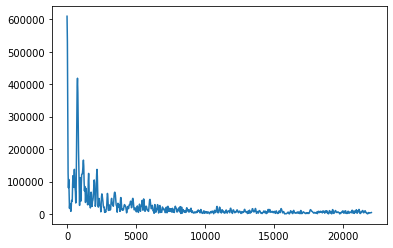

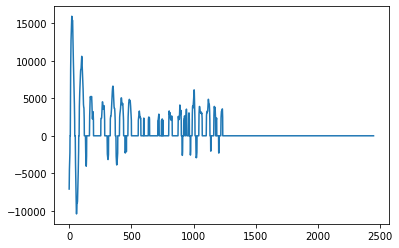

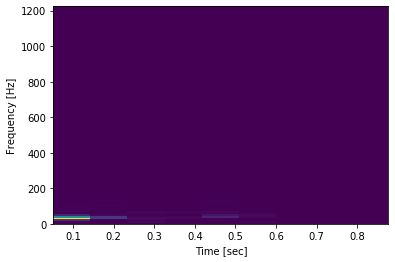

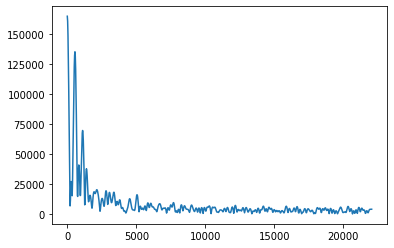

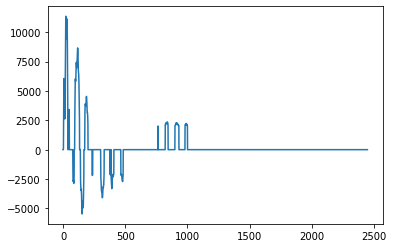

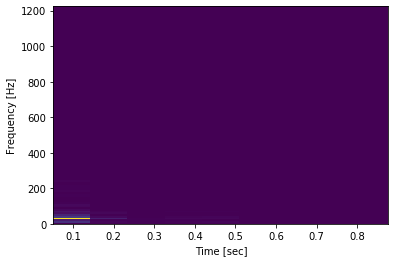

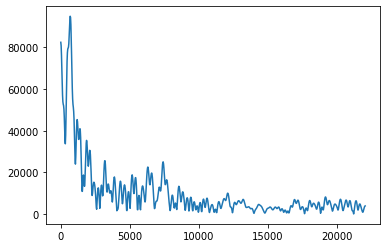

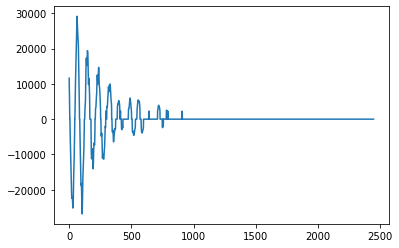

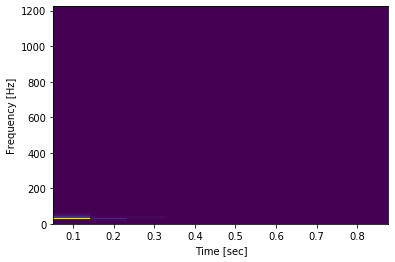

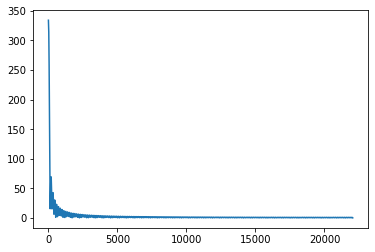

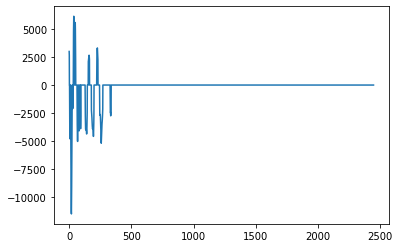

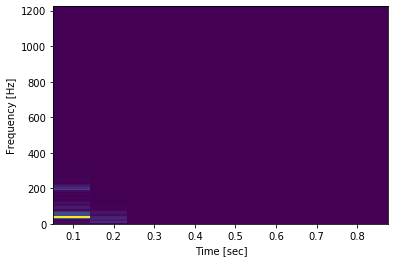

In [174]:
from scipy import signal as scisig
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

def tapDataHandler(tap):
    filtered = list(map(lambda x: x if x > 2000 or x < -2000 else 1,tap))
    centered = centerTap(filtered)
    return np.array((centered))

def byteArrayToTap(tapBytes):
    tapArray = []
    for byte in tapBytes:
        tapArray.extend(np.frombuffer(byte, dtype='<i2'))
    return tapArray

def centerTap(tap):
    tap = np.array(tap).tolist()
    startId = 0
    for freqId in range(0,len(tap)):
        if tap[freqId] > 5000:
            startId = freqId
            break
    startId += 500
    empty = np.zeros(len(tap)-(len(tap)-startId))
    centered = np.hstack([np.array(tap[startId:]),empty])
    return centered



for fileName in ["trainingTap0-1.wav","trainingTap1-19.wav","trainingTap2-15.wav","trainingTap3-11.wav"]:
    audio = pyaudio.PyAudio()
    wavFile = wave.open(fileName, 'rb')
    byteArray = wavFile.readframes(wavFile.getnframes())
    waveForm = tapDataHandler(np.frombuffer(byteArray, dtype='<i2'))#[850:720+750]
    wavfft = np.fft.rfft(np.array(waveForm))
    gfft = np.fft.rfft(gaussian(len(waveForm),.5))
    smooth = wavfft * gfft
    #waveForm = np.fft.ifft(smooth).real
    fs = len(waveForm)
    x = waveForm
    f, t, Sxx = scisig.spectrogram(x, fs)
    x,y = Sxx.shape    
    Sxx = np.reshape(Sxx, (y, x))
    Sxxx = np.array([s/max(s) for s in Sxx])
    for signal in Sxxx:
        maxFreqId = signal.tolist().index(max(signal.tolist()))
        #print(f[maxFreqId],signal[maxFreqId])
        
    freqs = np.linspace(0, rate/2., len(np.fft.rfft(np.array(waveForm[700:]))))
    plt.plot(freqs,(np.abs(np.fft.rfft(np.array(waveForm[700:])))))
    plt.show()
    
    
    plt.plot(waveForm)
    plt.show()
    plt.pcolormesh(t, f, np.reshape(Sxx, (x, y)))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()